<a href="https://colab.research.google.com/github/ericshermancs/detectron2/blob/master/final_copy_Detectron2_custom_coco_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
#!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__
torch.cuda.is_available()

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-n5najxvm
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-n5najxvm
     |████████████████████████████████| 276kB 18.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2-cp36-none-any.whl size=44589 sha256=68823ab951672e10099325de57a054f063285b3a6d112ac6c210d6db5d000935
  Stored in directory: /tmp/pip-ephem-wheel-cache-at41l477/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44620 sha256=cf88771c3fec17a55240d132d0d97ae3ee07c6cb5cc1a97ee3a572e081fb07d6
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for iopath: filename=iopath-0.1.2-cp36-none-any.whl size=10505 sha256=5cd5a81e182dc9ebe96578f6881157ce43099646a01298601d7d2731fa7f2933
  Stored in directory: /root/.cache/pip/wheels/9e/01/e

True

In [ ]:
# import our own detectron2 repo

!git clone https://github.com/ericshermancs/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9569 (delta 0), reused 0 (delta 0), pack-reused 9564
Receiving objects: 100% (9569/9569), 15.71 MiB | 33.94 MiB/s, done.
Resolving deltas: 100% (7014/7014), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.2MB 14.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
  Running setup.py develop for detectron2


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import importlib
import detectron2
# importlib.reload(detectron2)
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Train on a custom COCO dataset

In [ ]:
# uncomment below if access model and metadata from google drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# download, decompress the data
#!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
#!unzip data.zip > /dev/null

!wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.zip
# uncomment below if in your google drive
# !unzip /content/drive/MyDrive/cocostuff-10k-v1.1.zip -d cocostuff-10k-v1.1/ 
!mkdir downloads
!wget --directory-prefix=downloads http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/cocostuff-10k-v1.1.json
# uncomment below if in google drive
# !cp /content/drive/MyDrive/cocostuff-10k-v1.1.json downloads/cocostuff-10k-v1.1.json



In [ ]:
import json
ann_file = json.load(open('downloads/cocostuff-10k-v1.1.json'))
id_list = [x["id"] for x in ann_file['annotations']]

from collections import Counter
import pycocotools
counter = Counter(id_list)
duplicates_set = {i[0] for i in counter.most_common() if i[1]>1}
max_id = max(id_list)

dupe_counter = 1
rle_ann_list = []
for annotation in ann_file['annotations']:
    _id = annotation['id']
    if 'iscrowd' in annotation:
        if annotation['iscrowd'] == 1:
            rle_ann_list.append(annotation)
        annotation['iscrowd'] = 0
        
        
    if _id in duplicates_set:
        annotation['id'] = max_id + dupe_counter
        dupe_counter += 1

    if isinstance(annotation['segmentation'], list):
        if isinstance(annotation['segmentation'][0], dict):

            decoding = pycocotools.mask.decode(annotation['segmentation'][0])

            _contours, hierarchy = cv2.findContours(decoding, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
            contours = map(np.squeeze, _contours)  # removing redundant dimensions
            coords = []
            for cont in contours:
                coords.append(cont.flatten().tolist())

            annotation['segmentation'] = coords
    
    if isinstance(annotation['bbox'][0], list):
      annotation['bbox'] = annotation['bbox'][0]
    
    
with open('downloads/cocostuff_unique.json', 'w+') as outfile:
    json.dump(ann_file, outfile)

In [ ]:
#from detectron2.data.datasets import register_coco_instances
#register_coco_instances("fruits_nuts", {}, "./data/trainval.json", "./data/images")
import time
from detectron2.data.datasets import register_coco_instances
CURRENT_CATALOG_NAME = str(time.time())
register_coco_instances( CURRENT_CATALOG_NAME, {}, 'downloads/cocostuff_unique.json' ,'./cocostuff-10k-v1.1/images' )

In [ ]:

fruits_nuts_metadata = MetadataCatalog.get( CURRENT_CATALOG_NAME )
#coco10k_metadata = MetadataCatalog.get( 'COCO10k' )
dataset_dict = DatasetCatalog.get( CURRENT_CATALOG_NAME )

[12/13 04:07:20 d2.data.datasets.coco]: Loading downloads/cocostuff_unique.json takes 6.59 seconds.
WARNING [12/13 04:07:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/13 04:07:20 d2.data.datasets.coco]: Loaded 10000 images in COCO format from downloads/cocostuff_unique.json
WARNING [12/13 04:07:21 d2.data.datasets.coco]: Filtered out 12 instances without valid segmentation. There might be issues in your dataset generation process. A valid polygon should be a list[float] with even length >= 6.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
#cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = (CURRENT_CATALOG_NAME,)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 8
#cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_C4_1x/137257644/model_final_721ade.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 11
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 1500    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 183  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print( 'before trainer' )
trainer = DefaultTrainer(cfg)
print('after trainer')
trainer.resume_or_load(resume=False)
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (CURRENT_CATALOG_NAME, )
predictor = DefaultPredictor(cfg)

./output/model_final.pth


Then, we randomly select several samples to visualize the prediction results.

--2020-12-12 22:48:08--  http://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg
Resolving farm5.staticflickr.com (farm5.staticflickr.com)... 13.225.211.163, 2600:9000:2015:4800:0:5a51:64c9:c681, 2600:9000:2015:7200:0:5a51:64c9:c681, ...
Connecting to farm5.staticflickr.com (farm5.staticflickr.com)|13.225.211.163|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg [following]
--2020-12-12 22:48:08--  https://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg
Connecting to farm5.staticflickr.com (farm5.staticflickr.com)|13.225.211.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘test.png’

test.png                [ <=>                ] 130.21K  --.-KB/s    in 0.02s   

2020-12-12 22:48:08 (7.18 MB/s) - ‘test.png’ saved [133338]

<class 'detectron2.engine.defaults.DefaultPredictor'>


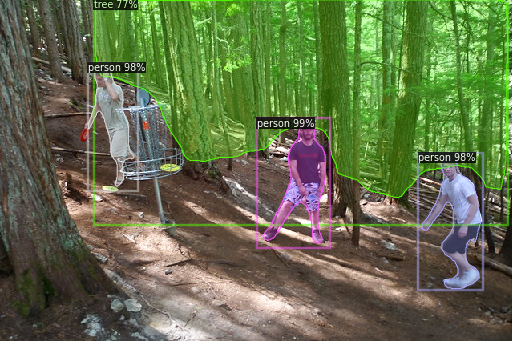

In [ ]:
from detectron2.utils.visualizer import ColorMode

!wget http://farm5.staticflickr.com/4099/4747850280_8bd283f328_z.jpg -O test.png
im = cv2.imread("test.png")
print(type(predictor))
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=fruits_nuts_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine.custom import CustomPredictor
MODEL_PATH = '/content/drive/MyDrive/torch_model.pth'
# metadata = '/content/drive/MyDrive/metadata.txt'
p = CustomPredictor(trainer.model)
p.load_metadata(fruits_nuts_metadata)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(CURRENT_CATALOG_NAME, ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, CURRENT_CATALOG_NAME )

print(inference_on_dataset(p.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/13 04:07:50 d2.data.datasets.coco]: Loading downloads/cocostuff_unique.json takes 8.69 seconds.
WARNING [12/13 04:07:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/13 04:07:50 d2.data.datasets.coco]: Loaded 10000 images in COCO format from downloads/cocostuff_unique.json
WARNING [12/13 04:07:50 d2.data.datasets.coco]: Filtered out 12 instances without valid segmentation. There might be issues in your dataset generation process. A valid polygon should be a list[float] with even length >= 6.
[12/13 04:07:51 d2.data.build]: Distribution of instances among all 171 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    person     | 22601        |    bicycle    | 552          |      car      | 3562         |
|  motorcycle   | 703          |   airplane    | 508      

/content/detectron2_repo/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


[12/13 04:07:55 d2.evaluation.evaluator]: Inference done 11/10000. 0.1039 s / img. ETA=0:18:29
[12/13 04:08:00 d2.evaluation.evaluator]: Inference done 56/10000. 0.1032 s / img. ETA=0:18:26
[12/13 04:08:05 d2.evaluation.evaluator]: Inference done 101/10000. 0.1042 s / img. ETA=0:18:30
[12/13 04:08:10 d2.evaluation.evaluator]: Inference done 146/10000. 0.1043 s / img. ETA=0:18:24
[12/13 04:08:15 d2.evaluation.evaluator]: Inference done 191/10000. 0.1048 s / img. ETA=0:18:19
[12/13 04:08:20 d2.evaluation.evaluator]: Inference done 237/10000. 0.1049 s / img. ETA=0:18:11
[12/13 04:08:25 d2.evaluation.evaluator]: Inference done 282/10000. 0.1051 s / img. ETA=0:18:07
[12/13 04:08:30 d2.evaluation.evaluator]: Inference done 328/10000. 0.1048 s / img. ETA=0:18:00
[12/13 04:08:35 d2.evaluation.evaluator]: Inference done 372/10000. 0.1051 s / img. ETA=0:17:59
[12/13 04:08:40 d2.evaluation.evaluator]: Inference done 416/10000. 0.1055 s / img. ETA=0:17:57
[12/13 04:08:45 d2.evaluation.evaluator]: 

TypeError: ignored